# Examine Sample Frequency In Replay Buffer
High epistemic uncertainty of a policy in Deep Reinforcement Learning might be caused by two factors:
* **Lack of data**: where an agent hasn't experienced to much in a state, then uncertainty about if the current policy is a trustable optimal policy.
* **Lack of training/learning**: where even though an agent has experienced a couple of times in a state, but the experiences have not been encoded into its policy.

Therefore, spending plenty of time exploiting an uncertain policy will waste much more time and energy and impede efficient learning. To speed up reduction of policy's uncertainty, two parallel solutions corresponding to the aforementioned two causal factors are:
* **Uncertainty-driven Active Exploring**: actively explore uncertain states according to an estimation of uncertainty to deal with lack of data problem.
* **Uncertainty-driven Mini-batch Sampling**: focus learning on uncertainty experiences that have been encountered but not yet been mastered in policy.


In this toy example, we will investigate the frequency of data been sampled to train.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer.
    """

    def __init__(self, size):
        self.index_buf = np.zeros([size, ], dtype=np.float32)
        self.count_buf = np.zeros([size, ], dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, x):
        self.index_buf[self.ptr] = x
        self.count_buf[self.ptr] = 0
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        if batch_size > self.size:
            batch_size = self.size
        idxs = np.random.randint(0, self.size, size=batch_size)
        # Count add 1 if being sampled
        self.count_buf[idxs] += 1
        
    def uncertainty_based_sample_batch(self, raw_batch_size = 100, batch_size=32):
        if raw_batch_size > self.size:
            raw_batch_size = self.size
        if batch_size> self.size:
            batch_size = self.size
        
        raw_idxs = np.random.randint(0, self.size, size=raw_batch_size)
        # Pick top n less trained data
        idxs = raw_idxs[np.argsort(self.count_buf[raw_idxs], axis=0)[:batch_size]]
        self.count_buf[idxs] += 1
        
        

## Random Mini-batch Sample

In [3]:
MAX_STEPS = 1000000
batch_size = 100
random_replay_buffer = ReplayBuffer(size=MAX_STEPS)

for i in range(MAX_STEPS):
    # Simulated add new data
    random_replay_buffer.store(i)
    
    # Simulated training
    if i >= batch_size:
        random_replay_buffer.sample_batch(batch_size)
    

## Uncertainty-based Mini-batch Sample

In [27]:
MAX_STEPS = 1000000
raw_batch_size = 500
batch_size = 100
uncertainty_based_replay_buffer = ReplayBuffer(size=MAX_STEPS)

for i in range(MAX_STEPS):
    # Simulated add new data
    uncertainty_based_replay_buffer.store(i)
    
    # Simulated training
    if i >= raw_batch_size:
        uncertainty_based_replay_buffer.uncertainty_based_sample_batch(raw_batch_size, batch_size)
    

### Plot sample frequency
From this figure, we can see that new added data are trained less frequently compared with data added earlier in the replay buffer. So under the assumption that each data is unique, new data will be lack of training.

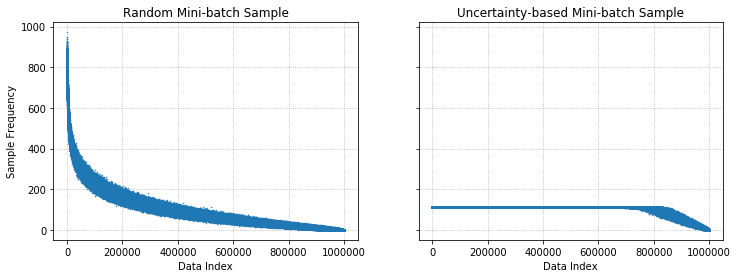

In [28]:
marker = '.'
markersize = 1
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(12)
fig.set_figheight(4)

axes[0].plot(random_replay_buffer.index_buf, random_replay_buffer.count_buf, marker, markersize=markersize)
axes[0].set_xlabel('Data Index')
axes[0].set_ylabel('Sample Frequency')
axes[0].set_title('Random Mini-batch Sample')
axes[0].grid(linestyle=':')

axes[1].plot(uncertainty_based_replay_buffer.index_buf, uncertainty_based_replay_buffer.count_buf, marker, markersize=markersize)
axes[1].set_xlabel('Data Index')
axes[1].set_title('Uncertainty-based Mini-batch Sample')
axes[1].grid(linestyle=':')


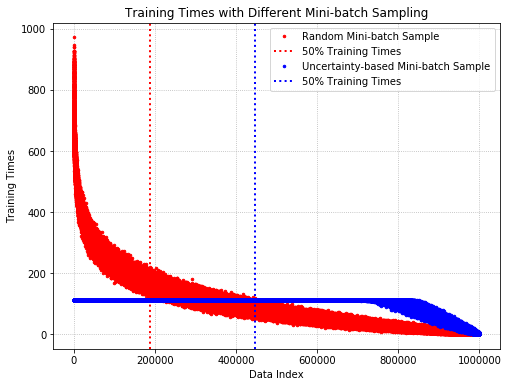

In [56]:
marker = '.'
markersize = 5
fig, axes = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(6)

axes.plot(random_replay_buffer.index_buf, random_replay_buffer.count_buf, marker, markersize=markersize, c='r')
axes.axvline(x=187000, linewidth=2, color='r', linestyle=':')

axes.plot(uncertainty_based_replay_buffer.index_buf, uncertainty_based_replay_buffer.count_buf, marker, markersize=markersize, c='b')
axes.axvline(x=447000, linewidth=2, color='b', linestyle=':')

axes.set_xlabel('Data Index')
axes.set_ylabel('Training Times')
axes.legend(['Random Mini-batch Sample', '50% Training Times',
             'Uncertainty-based Mini-batch Sample', '50% Training Times'])
axes.set_title('Training Times with Different Mini-batch Sampling')
axes.grid(linestyle=':')

fig.savefig('random_batch_vs_uncertainty_based_batch.jpg', dpi=300)


In [46]:
# for i in range(MAX_STEPS):
#     if np.sum(random_replay_buffer.count_buf[:i]) / np.sum(random_replay_buffer.count_buf) >=0.5:
#         print(i)
#         break

In [44]:
np.sum(random_replay_buffer.count_buf[:187000]) / np.sum(random_replay_buffer.count_buf)

0.5003111

In [52]:
np.sum(uncertainty_based_replay_buffer.count_buf[:447000]) / np.sum(uncertainty_based_replay_buffer.count_buf)

0.5004719